In [1]:
#meta.py


from matplotlib import image
from matplotlib import pyplot
import matplotlib.pyplot as plt

import numpy as np
import os


import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.optim import Optimizer

import scipy
from scipy import stats
import copy

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #channel2 = 16

        #channel1 = 16
        channel1 = 32
        channel2 = 16
        maxPool2 = 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=channel1,
                kernel_size=7,
                stride=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        #self.conv2 = nn.Sequential(
        #    nn.Conv2d(channel1, channel2, 7, 1),
        #    nn.ReLU(),
        #    nn.MaxPool2d(maxPool2),
        #)
        self.conv2 = nn.Sequential(
            nn.Conv2d(channel1, channel2, 7, 1),
            nn.Tanh(),
            nn.MaxPool2d(maxPool2),
        )
        # fully connected layer, output 10 classes
        #self.out = nn.Linear(32 * 7 * 7, 10)
        #self.out = nn.Linear(channel2 * 8 * 8, 1)
        #self.out = nn.Linear(channel2 * 7 * 7, 1)
        self.out = nn.Linear(channel2 * 5 * 5, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.reshape(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization
class returnVector(nn.Module):
    def __init__(self, N):
        super(returnVector, self).__init__()

        channel2 = 16

        self.Weights = torch.nn.Parameter(torch.rand(N) - 0.5)


    def forward(self):

        return self.Weights
class linearOutput(nn.Module):
    def __init__(self):
        super(linearOutput, self).__init__()

        channel2 = 16

        # self.out = nn.Linear( (channel2 * 5 * 5) + 3 , 1)
        self.out1 = nn.Linear(400, 8)
        self.out = nn.Linear( 8 , 1)


    def forward(self, x):
        x = self.out1(x)
        return self.out(x), ''
class weightModel(nn.Module):
    def __init__(self):
        super(weightModel, self).__init__()

        channel2 = 16

        #self.lin1 = nn.Linear( (channel2 * 5 * 5) + 1 , 3)
        self.lin1 = nn.Linear( 2 , 20)

        self.lin2 = nn.Linear( 20  , 1)
        # self.lin1 = nn.Linear(2, 5)
        # self.lin2 = nn.Linear(5, 5)
        # # self.lin3 = nn.Linear(10, 10)
        # self.lin4 = nn.Linear(5, 5)
        # self.lin5 = nn.Linear(5, 1)

        # self.dropout = nn.Dropout(p=0.4)


    def forward(self, x):

        x = self.lin1(x)
        x = torch.relu(x)
        # x = self.dropout(x)
        x = self.lin2(x)
        # x = torch.relu(x)
        # # x = self.lin3(x)
        # # x = torch.relu(x)
        # # x = self.dropout(x)
        # x = self.lin4(x)
        # x = torch.relu(x)
        # x = self.lin5(x)

        return x, ''

# model = weightModel()
# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# params = sum([np.prod(p.size()) for p in model_parameters])
# print(params)    

def loadnpz(name, allow_pickle=False):
    if allow_pickle:
        data = np.load(name, allow_pickle=True)
    else:
        data = np.load(name)
    data = data.f.arr_0
    return data
def doDownSample(image, downSize):

    size1 = image.shape[0] // downSize
    image = image[:(size1*downSize), :(size1*downSize)]

    image = image.reshape((image.shape[0] // downSize, downSize, image.shape[1] // downSize, downSize, 3))
    image = np.sum(image, axis=(1, 3))
    image = image // (downSize **  2)

    return image
def downSampler():

    folder1 = './Age/crop_part1/'
    fNames = os.listdir(folder1)

    downSize = 5

    allImages = np.zeros((len(fNames), 200 // downSize, 200 // downSize, 3), dtype=int)
    ageList = np.zeros(len(fNames), dtype=int)

    for a in range(len(fNames)):

        print (a)
        fname = fNames[a]

        age1 = int(fname.split('_')[0])

        ageList[a] = age1


        image2 = image.imread(folder1 + fname)


        image2 = doDownSample(image2, downSize)

        allImages[a] = np.copy(image2)

    np.savez_compressed('./Age/data/allImages.npz', allImages)
    np.savez_compressed('./Age/data/allAges.npz', ageList)
def calculateGradVector(model, sizeTotal):

    count1 = 0
    gradNow = np.zeros((sizeTotal,))
    for param in model.parameters():
        size1 = param.nelement()
        grad1 = param.grad
        #print (grad1)
        grad1 = grad1.data.numpy()
        grad1 = grad1.reshape((size1,))

        gradNow[count1:count1+size1] = np.copy(grad1)
        count1 += size1

    return gradNow
def findDataGrad(X, Y, model, optimizer, sizeTotal):

    dataGrad = np.zeros((X.shape[0],  sizeTotal))

    for a in range(X.shape[0]):
        pred1, _ = model(X[a:a+1])

        loss1 = (pred1[0, 0] - Y[a]) ** 2
        loss1.backward()

        gradNow = calculateGradVector(model, sizeTotal)
        dataGrad[a] = np.copy(gradNow)

        optimizer.zero_grad()

    return dataGrad
def trainModel(cv = 0):

    useMeta = False


    X = loadnpz('./Age/data/allImages.npz')
    Y = loadnpz('./Age/data/allAges.npz')

    #print (X.shape)
    #quit()

    #plt.hist(Y, bins=100)
    #plt.show()
    #quit()

    Y = Y / 100
    X = np.swapaxes(X, 1, 3)
    X = np.swapaxes(X, 2, 3)

    minAge_test = 0.14
    maxAge_test = 0.21

    #minAge_valid = 0.12
    #maxAge_valid = 0.23
    minAge_valid = 0.14
    maxAge_valid = 0.21





    N = Y.shape[0]
    rng = np.random.RandomState(0)
    perm1 = rng.permutation(N)
    X = X[perm1]
    Y = Y[perm1]

    N_test = 1000
    # X_test = X[:N_test]
    # Y_test = Y[:N_test]
    X_test = X[N_test*cv:N_test*cv+N_test]
    Y_test = Y[N_test*cv:N_test*cv+N_test]
    X = np.concatenate((X[:N_test*cv], X[N_test*cv + N_test:]), axis=0) 
    Y = np.concatenate((Y[:N_test*cv], Y[N_test*cv + N_test:]), axis=0) 
    # X = X[N_test:]
    # Y = Y[N_test:]
    if useMeta:
        N_valid = 1000
        X_valid = X[:N_valid]
        Y_valid = Y[:N_valid]
        X = X[N_valid:]
        Y = Y[N_valid:]


        validArg = np.argwhere(np.logical_and(Y_valid >= minAge_valid, Y_valid <= maxAge_valid))[:, 0]
        X_valid = X_valid[validArg]
        Y_valid = Y_valid[validArg]

        X_valid = torch.tensor(X_valid).float()
        Y_valid = torch.tensor(Y_valid).float()


    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    X_test = torch.tensor(X_test).float()
    Y_test = torch.tensor(Y_test).float()




    metaTest = False

    if metaTest:
        testArg = np.argwhere(np.logical_and(Y_test.data.numpy() >= minAge_test, Y_test.data.numpy() <= maxAge_test))[:, 0]
        X_test = X_test[testArg]
        Y_test = Y_test[testArg]


    restrictTrain = False
    if restrictTrain:
        trainArg = np.argwhere(np.logical_and(Y.data.numpy() >= minAge_test, Y.data.numpy() <= maxAge_test))[:, 0]
        X = X[trainArg]
        Y = Y[trainArg]

    #print (X.shape)
    #quit()


    N_train = Y.shape[0]


    #model = torch.load('./models/2.pt')
    model = CNN().to('cuda')


    sizeTotal = 0
    for param in model.parameters():
        size1 = param.nelement()
        sizeTotal += size1



    #learningRate = 1e-3
    #learningRate = 5e-4
    #learningRate = 3e-4
    learningRate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)


    iterN = 100
    batchSize = 100
    Nbatch = N_train // batchSize

    trainLoss = []

    for iter in range(iterN):

        for batchNum in range(Nbatch):

            X_batch = X[batchNum*batchSize:(batchNum+1)*batchSize].to('cuda')
            Y_batch = Y[batchNum*batchSize:(batchNum+1)*batchSize].to('cuda')

            if useMeta:
                dataGrad = findDataGrad(X_batch, Y_batch, model, optimizer, sizeTotal)


                pred_valid, _ = model(X_valid)
                pred_valid = pred_valid[:, 0]
                loss_Valid = torch.mean((pred_valid - Y_valid) ** 2)
                loss_Valid.backward()

                validGrad = calculateGradVector(model, sizeTotal)
                validDir = validGrad
                validDir = validDir.reshape((1, validDir.shape[0]))

                dataValue = np.sum(validDir * dataGrad, axis=1)

                #norm1 = np.sum(validDir**2, axis=1) ** 0.5
                #norm2 = np.sum(dataGrad**2, axis=1) ** 0.5
                #dataValue = dataValue / (norm1 * norm2)

                #plt.scatter(Y_batch.data.numpy(), dataValue)
                #plt.show()
                #quit()

                #weighting = np.zeros(dataValue.shape[0])
                #weighting[dataValue > 0] = 1

                weighting = np.copy(dataValue) / 2
                weighting[weighting<0] = 0
                weighting[weighting>1] = 1

                #print (torch.mean(Y_batch[dataValue > 0]), torch.mean(Y_batch))



                weighting = torch.tensor(weighting).float()




            pred, _ = model(X_batch)
            pred = pred[:, 0]
            loss = (pred - Y_batch) ** 2

            if useMeta:
                loss = loss * weighting

            loss = torch.mean(loss)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #print ('range')
        #print (np.quantile(Y_batch[dataValue > 0].data.numpy(), np.array([0.25, 0.75])))
        #print (np.quantile(Y_batch.data.numpy(), np.array([0.25, 0.75])))


        pred_test, _ = model(X_test.to('cuda'))
        pred_test = pred_test[:, 0]

        cor_test = scipy.stats.pearsonr(pred_test.to('cpu').data.numpy(), Y_test.data.numpy())

        if useMeta:
            pred_valid, _ = model(X_valid.to('cuda'))
            pred_valid = pred_valid[:, 0]

            #print (pred_valid.shape, Y_valid.shape)
            cor_valid = scipy.stats.pearsonr(pred_valid.to('cpu').data.numpy(), Y_valid.data.numpy())

        pred_train, _ = model(X[:N_test].to('cuda'))
        pred_train = pred_train[:, 0]

        cor_train = scipy.stats.pearsonr(pred_train.to('cpu').data.numpy(), Y[:N_test].data.numpy())

        lossInfo = [cor_train[0], cor_test[0]]

        #print ("Scores")
        print ('iter', iter)
        print (cor_train)
        if useMeta:
            print (cor_valid)
            lossInfo = [cor_train[0], cor_valid[0], cor_test[0]]
        print (cor_test)

        trainLoss.append(copy.copy(lossInfo))

        #np.save('./results/trainLoss_someData.npy', np.array(trainLoss))
        #torch.save(model, './models/1_someData.pt')

        torch.save({'state_dict': model.state_dict()}, './models/cv_'+str(cv)+'pt')


In [9]:
def target_func(W):
    return 1/(torch.abs(W)**2 + 1)
    # return 1+torch.tanh(W)
def target_func_np(W):
    return 1/(np.abs(W)**2 + 1)
    # return 1 + np.tanh(W)

def trainWeightingLinear(useMeta = True, restrictTrain = False, iterN = 1000, vcv = 0, cv=0, wmodel=None):

    # useMeta = False

    # Load in Data + Preprocessing
    X = loadnpz('./Age/data/allImages.npz')
    Y = loadnpz('./Age/data/allAges.npz')

    Y = Y / 100
    X = np.swapaxes(X, 1, 3)
    X = np.swapaxes(X, 2, 3)

    minAge_test = 0.14
    maxAge_test = 0.21

    minAge_valid = 0.14
    maxAge_valid = 0.21

    featureModel = CNN()
    checkpoint = torch.load('models/cv_'+str(cv)+'.pt')
    featureModel.load_state_dict(checkpoint['state_dict'])

    # featureModel = torch.load('./models/3.pt')

    N = Y.shape[0]
    rng = np.random.RandomState(0)
    #rng = np.random.RandomState(1)
    #rng = np.random.RandomState(2)
    perm1 = rng.permutation(N)
    X = X[perm1]
    Y = Y[perm1]


    X = torch.tensor(X).float()
    originalPred, X = featureModel(X)
    X = X.data.numpy()
    onesAdd = np.ones((X.shape[0], 1), dtype=float)
    X = np.concatenate((X,onesAdd), axis=1)

    originalPred = originalPred.data.numpy()
    originalPred = torch.tensor(originalPred).float()

    N_test = 1000
    X_test = X[N_test*cv:N_test*cv+N_test]
    Y_test = Y[N_test*cv:N_test*cv+N_test]
    X = np.concatenate((X[:N_test*cv], X[N_test*cv + N_test:]), axis=0) 
    Y = np.concatenate((Y[:N_test*cv], Y[N_test*cv + N_test:]), axis=0)
    # X_test = X[:N_test]
    # Y_test = Y[:N_test]
    originalPred = torch.cat((originalPred[:N_test*cv], originalPred[N_test*cv + N_test:]), axis=0) 
    # X = X[N_test:]
    # Y = Y[N_test:]
    originalPred_test = originalPred[N_test*cv:N_test*cv+N_test]
    # print(originalPred.shape)
    
    
    if useMeta:
        # BUILD CROSS VALIDATION HERE
        N_valid = 1000
        X_valid = X[N_valid*vcv:N_valid*vcv+N_valid]
        Y_valid = Y[N_valid*vcv:N_valid*vcv+N_valid]
        originalPred_valid = originalPred[N_valid*vcv:N_valid*vcv+N_valid]
        X = np.concatenate((X[:N_valid*vcv], X[N_valid*vcv + N_valid:]), axis=0) 
        Y = np.concatenate((Y[:N_valid*vcv], Y[N_valid*vcv + N_valid:]), axis=0) 
        originalPred = torch.cat((originalPred[:N_valid*vcv], originalPred[N_valid*vcv + N_valid:]), axis=0) 


        validArg = np.argwhere(np.logical_and(Y_valid >= minAge_valid, Y_valid <= maxAge_valid))[:, 0]
        X_valid = X_valid[validArg]
        Y_valid = Y_valid[validArg]
        originalPred_valid = originalPred_valid[validArg]

        X_valid = torch.tensor(X_valid).float()
        Y_valid = torch.tensor(Y_valid).float()
        
        

    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    X_test = torch.tensor(X_test).float()
    Y_test = torch.tensor(Y_test).float()


    metaTest = True

    if metaTest:
        testArg = np.argwhere(np.logical_and(Y_test.data.numpy() >= minAge_test, Y_test.data.numpy() <= maxAge_test))[:, 0]
        X_test = X_test[testArg]
        Y_test = Y_test[testArg]
        originalPred_test = originalPred_test[testArg]


    
    if restrictTrain:
        #trainArg = np.argwhere(np.logical_and(Y.data.numpy() >= minAge_valid, Y.data.numpy() <= maxAge_valid))[:, 0]
        trainArg = np.argwhere(np.logical_and(Y.data.numpy() >= minAge_test, Y.data.numpy() <= maxAge_test))[:, 0]
        X = X[trainArg]
        Y = Y[trainArg]
        originalPred = originalPred[trainArg]

    N_train = Y.shape[0]

    predModel = weightModel()


    learningRate = 5e-3
    optimizer = torch.optim.Adam(predModel.parameters(), lr = learningRate)

    #learningRate = 1e-3
    #learningRate = 1e-4
    #optimizer = torch.optim.RMSprop(predModel.parameters(), lr = learningRate)

    #learningRate = 1e-1
    #optimizer = torch.optim.SGD(predModel.parameters(), lr = learningRate)


    # iterN = 1000
    batchSize = 100
    Nbatch = N_train // batchSize

    testloss = []
    testcorr = []
    best_err = 10000
    best_model = None

    if useMeta or wmodel != None:
        X_both = torch.cat(( (Y-0.18).reshape((-1, 1)) , (originalPred-0.18) ), axis=1) * 5
        # plt.scatter(100*(X_both[:, 0]/5 + 0.18), 100*(X_both[:, 1]/5 + 0.18))
        # plt.show()

    for iter in range(iterN):
        if useMeta:
            #W = predModel()
            #W = (torch.tanh(W) + 1) / 1
            #W = W.reshape((W.shape[0], 1))

            #W, _ = predModel(X[:, :-1])
            #W = (torch.tanh(W) + 1) / 1

            #X_both = torch.cat((X[:, :-1], Y.reshape((-1, 1)) * 10  ), axis=1)



            #X_both = torch.cat((X[:, :-1] * 0, (Y-0.18).reshape((-1, 1)) , torch.abs(Y-0.18).reshape((-1, 1)) , ((Y-0.18)**2).reshape((-1, 1))  ), axis=1)
            #X_both = torch.cat(( (Y-0.18).reshape((-1, 1)) , torch.abs(Y-0.18).reshape((-1, 1)) , ((Y-0.18)**2).reshape((-1, 1)) , (originalPred-0.18), torch.abs(originalPred-0.18) , (originalPred-0.18) ** 2, torch.abs(Y.reshape((-1, 1)) - originalPred), (Y.reshape((-1, 1)) - originalPred)**2  ), axis=1)
            
            W, _ = predModel(X_both)
            # W =  1 / torch.log( torch.exp(-1 * W) + np.exp(1.0) )
            # W = 1 + torch.tanh(W)
            W = target_func(W)
            if(iter%10 == 0):
                print(W.shape, torch.argwhere(W > 0.1).shape)

        elif wmodel != None:
            # X_both = torch.cat(( (Y-0.18).reshape((-1, 1)) , (originalPred-0.18) ), axis=1) * 5
            W, _ = wmodel(X_both)
            # W = (torch.tanh(W) + 1) / 1
            W = target_func(W)
            print("using pretrained weights")
            
        else:
            W = torch.ones((X.shape[0], 1))

        XW = (W * X).T

        XX_mat = torch.matmul(XW, X)

        #print (XX_mat)
        #print ((1e-1 * X.shape[0]))
        #quit()

        ridgeReg = 5e-3
        #ridgeReg = 1e-2
        # ridgeReg = 2e-2
        #ridgeReg = 1e-1

        XX_mat_inv = torch.inverse(XX_mat + (ridgeReg * X.shape[0] * torch.eye(XX_mat.shape[0]))  )
        XY_mat = torch.matmul(XW, Y)

        weightBeta = torch.matmul(XX_mat_inv, XY_mat)

        weightBeta = weightBeta.reshape((-1, 1))


        pred_train = torch.matmul(X, weightBeta)
        pred_train = pred_train[:, 0]

        #print (np.mean(Y.data.numpy()))
        #print (np.mean(pred_train.data.numpy()))
        #print (np.mean(   (pred_train.data.numpy() -  Y.data.numpy())  **2 ))
        #quit()

        # cor_train = scipy.stats.pearsonr(pred_train.data.numpy(), Y.data.numpy())


        pred_test = torch.matmul(X_test, weightBeta)
        pred_test = pred_test[:, 0]
        cor_test = scipy.stats.pearsonr(pred_test.data.numpy(), Y_test.data.numpy())

        if useMeta:
            pred_valid = torch.matmul(X_valid, weightBeta)
            pred_valid = pred_valid[:, 0]
            # cor_valid = scipy.stats.pearsonr(pred_valid.data.numpy(), Y_valid.data.numpy())
        
        
        testloss.append(torch.mean((pred_test - Y_test) ** 2).data.numpy())
        
        if(testloss[-1] < best_err):
            best_err = testloss[-1]
            best_model = predModel


        if(iter % 20 == 0):
            print (iter)
            # print (cor_train)

            # if useMeta:
                # print (cor_valid)
            # print (cor_test, testloss[-1])
            print('test', testloss[-1])
            if(useMeta):
                print('valid', torch.mean((pred_valid - Y_valid) ** 2).data.numpy())
        testcorr.append(cor_test)
        



        if not useMeta:
            acc = 0
            return acc, torch.mean((pred_test - Y_test) ** 2).data.numpy()

        if useMeta:

            loss = torch.mean(  (pred_valid - Y_valid) ** 2)
            # loss = torch.mean(  torch.abs(pred_valid - Y_valid))

            #pred_valid = pred_valid - torch.mean(pred_valid) + torch.mean(Y_valid)
            #loss = torch.mean(  torch.abs(pred_valid - Y_valid))


            #reg = 0
            #for param in predModel.parameters():
            #    reg += torch.sum(torch.abs(param))

            #loss = loss + (2e-5 * reg)
            #loss = loss + (1e-4 * reg)
            #loss = loss + (1e-3 * reg)
            #loss = loss + (1e-2 * reg)


            optimizer.zero_grad()
            loss.backward()


            torch.nn.utils.clip_grad_value_(predModel.parameters(), 1e-4) #good

            #torch.nn.utils.clip_grad_value_(predModel.parameters(), 2e-5)

            optimizer.step()
        if(iter % 500 == 499):
            hm(predModel)
            

    predModel.eval()
    finalCor = trainWeightingLinear(useMeta = False, restrictTrain = False, iterN = 1000, vcv = vcv, cv=cv, wmodel=best_model)
    cor_train = 0
    cor_valid = 0
    return best_model, cor_train, cor_valid, finalCor, testloss, testcorr


In [4]:
def hm(model):
    heat_map = np.zeros((100, 100))
    scaled_heat_map = np.zeros((100, 100))
    r = 0
    c = 0
    # m = torch.load('models/weights.pt')
    m = model
    with torch.no_grad():
        m.eval()
        for t in [i/100 for i in range(1, 101)]:
            c = 0
            for p in [i/100 for i in range(1, 101)]:
                inp = torch.Tensor(np.array([5*(t - 0.18), 5*(p-0.18)]))
                # print(inp.shape)
                heat_map[r, c] = m(inp)[0].item()
                # scaled_heat_map[r, c] =1/(np.exp(heat_map[r, c] * -1) +1 )
                # scaled_heat_map[r, c] = np.tanh(heat_map[r, c]) + 1
                scaled_heat_map[r, c] = target_func_np(heat_map[r, c])
                # print(t, p, heat_map[r, c])
                c+=1
            r+=1

    plt.imshow(scaled_heat_map, extent=[1, 100, 100, 1])
    plt.colorbar()
    plt.xlabel('predicted age')
    plt.ylabel('actual age')
    plt.title('Data Reweighting')
    plt.show()
    # plt.imshow(heat_map, extent=[14, 100, 100, 14])
    # plt.colorbar()
    # plt.xlabel('predicted age')
    # plt.ylabel('actual age')
    # plt.title('Data Reweighting (logits)')

In [ ]:
# for i in range(8):
#     trainModel(cv=i)

# trainModel(cv=4)
# trainModel(cv=7)

In [ ]:
all = []
all_err = []
rest = []
rest_err = []
tr = []
tr_err = []
va = []
te = []
trl = []
trc = []
# fr = []
models = []
for cv in range(8):
    print('=======================', cv, '======================')
    corr_all, loss_all = trainWeightingLinear(useMeta = False, restrictTrain=False, cv = cv)
    # all.append(corr_all[0])
    all_err.append(loss_all)
    # trainWeightingLinear(iterN = 600, cv=cv)
    corr_restrict, loss_restrict = trainWeightingLinear(useMeta = False, restrictTrain=True, cv = cv)
    # rest.append(corr_restrict[0])
    rest_err.append(loss_restrict)

    model, t, v, tt, trloss, trcorr = trainWeightingLinear(iterN = 2000, cv=cv, vcv = 2)
    # tr.append(t)
    # va.append(v)
    te.append(tt)
    trl.append(trloss)
    # trc.append(trcorr)
    models.append(model)
    # fr.append(fres)



In [ ]:
i = 0
for p in trl:
    s = [x for x in p]
    plt.plot(s, label=str(i))
    plt.scatter([990, 790], [all_err[i], rest_err[i]], label=str(i))
    # plt.scatter([4890], rest[i], label = str(i))
    i+=1
# plt.scatter([4990]*len(trl), all)
# plt.scatter([4950]*len(trl), rest)
plt.legend()
plt.show()

m = np.mean(np.array(trl), axis=0)
s = np.std(np.array(trl), axis=0)
r = 100

tet = [x[0] for x in te]
print(tet)

plt.errorbar(r*np.arange(m[::r].shape[0]), m[::r], yerr=s[::r], label='ours')
plt.errorbar([990], np.mean(all_err), yerr = np.std(all_err), label='all')
plt.errorbar([990], np.mean(rest_err), yerr = np.std(rest_err), label='restricted')
plt.errorbar([1500], np.mean(tet), yerr = np.std(tet), label='ourfinal')
plt.legend()
plt.show()
print(m[-1], np.mean(all_err), np.mean(rest_err))

true_res = []
max_res = []
for idx, model in enumerate(models):
    s = [x for x in trl[idx]]
    print(s[-1], all_err[idx], rest_err[idx], idx)
    max_res.append(np.max(s))
    model.eval()
    acc, err = trainWeightingLinear(useMeta = False, restrictTrain = False, cv=idx, wmodel=model)
    true_res.append(err)
    # print(acc)
    hm(model)

print(true_res)
print(rest_err)
print(all_err)

plt.plot(true_res)
plt.plot(rest_err)
plt.show()
print(np.mean(true_res))
print(np.mean(max_res))
print(np.mean(rest))
print(np.mean(all))

In [ ]:
# model, t, v, tt, trloss = trainWeightingLinear(iterN = 1000, cv=6, vcv = 2)
plt.scatter(np.arange(8), [400*i for i in true_res], label='Ours')
plt.scatter(np.arange(8), [400*i for i in rest_err], label='Restricted')
plt.legend()
plt.xlabel('Test Split')
plt.ylabel('Mean Square Error (Years^2)')
print()
plt.show()


plt.plot([1 - true_res[i]/rest_err[i] for i in range(8)])
np.mean([true_res[i]/rest_err[i] for i in range(8)])
plt.show()
st = [400*i for i in true_res]
sr = [400*i for i in rest_err]
sa = [400*i for i in all_err]

diff = [sr[i] - st[i] for i in range(8)]
print(diff)
print(np.std(st), np.mean(st))
print(np.std(sr), np.mean(sr))
print(np.std(sa), np.mean(sa))
print(np.std(diff), np.mean(diff))

# np.savetxt('ours_scaled.txt', st)
# np.savetxt('rest_scaled.txt', sr)
# np.savetxt('all_scaled.txt', sa)

t = np.loadtxt('ours_scaled.txt')
r = np.loadtxt('rest_scaled.txt')
a = np.loadtxt('all_scaled.txt')

stt = np.concatenate((st, t))
srr = np.concatenate((sr, r))
saa = np.concatenate((sa, a))

plt.scatter(np.arange(16), stt, label='Ours')
plt.scatter(np.arange(16), srr, label='Restricted')
plt.legend()
plt.show()
diff2 = [srr[i] - stt[i] for i in range(16)]
print(diff)
print(np.std(stt), np.mean(stt))
print(np.std(srr), np.mean(srr))
print(np.std(saa), np.mean(saa))
print(np.std(diff2), np.mean(diff2))

In [ ]:
s = [x[0] for x in trloss]
ind = 5

plt.scatter([4990, 4590], [all[ind], rest[ind]], label=str(ind))
plt.plot(s)
rep = True
if rep:
    trl[ind] = trloss
    models[ind] = model
    tr[ind] = t
    va[ind] = v
    te[ind] = tt

In [ ]:
t = np.loadtxt('ours_scaled.txt')
r = np.loadtxt('rest_scaled.txt')
a = np.loadtxt('all_scaled.txt')
plt.scatter(np.arange(8), t, label='Ours')
plt.scatter(np.arange(8), r, label='Restricted')
plt.xlabel('Train/Test Split Number')
plt.ylabel('Mean Squared Error (Years^2)')
plt.legend()


In [ ]:
al = []
rl = []
ml = []
for cv in range(8):
    print('=======================', cv, '======================')
    loss_all = trainWeightingLinear(useMeta = False, restrictTrain=False, cv = cv)
    al.append(loss_all[0])
    # trainWeightingLinear(iterN = 600, cv=cv)
    loss_restrict = trainWeightingLinear(useMeta = False, restrictTrain=True, cv = cv)
    rl.append(loss_restrict[0])

    loss_model = trainWeightingLinear(useMeta = False, iterN = 2000, cv=cv, vcv = 2, wmodel = models[7])
    ml.append(loss_model[0])

print(np.mean(al), np.mean(rl), np.mean(ml))

torch.Size([7780, 1]) torch.Size([7780, 2])
0
test 0.01789844
valid 0.010555065
torch.Size([7780, 1]) torch.Size([7780, 2])
torch.Size([7780, 1]) torch.Size([7766, 2])
20
test 0.012168354
valid 0.0073870514
torch.Size([7780, 1]) torch.Size([7260, 2])
torch.Size([7780, 1]) torch.Size([6355, 2])
40
test 0.007731425
valid 0.00501476
torch.Size([7780, 1]) torch.Size([5580, 2])
torch.Size([7780, 1]) torch.Size([5068, 2])
60
test 0.0047797184
valid 0.0035030735
torch.Size([7780, 1]) torch.Size([4709, 2])
torch.Size([7780, 1]) torch.Size([4409, 2])
80
test 0.003147128
valid 0.0025894651
torch.Size([7780, 1]) torch.Size([3775, 2])
torch.Size([7780, 1]) torch.Size([2216, 2])
100
test 0.0021208888
valid 0.001914877
torch.Size([7780, 1]) torch.Size([1731, 2])
torch.Size([7780, 1]) torch.Size([1402, 2])
120
test 0.0014168788
valid 0.001387778
torch.Size([7780, 1]) torch.Size([1200, 2])
torch.Size([7780, 1]) torch.Size([1061, 2])
140
test 0.00095718756
valid 0.0010340975
torch.Size([7780, 1]) torch

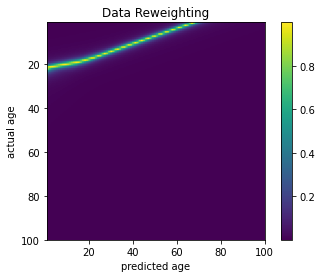

using pretrained weights
0
test 0.00043754806


In [10]:
model, t, v, tt, trloss, trcorr = trainWeightingLinear(iterN = 500, cv=7, vcv = 2)

Text(0, 0.5, 'Test Correlation')

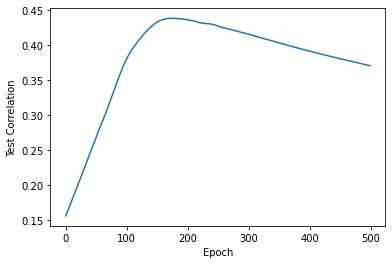

In [15]:
x = [x[0] for x in trcorr]
# print(trcorr)
plt.plot(x[0:], label='Ours (Current)')
plt.xlabel("Epoch")
plt.ylabel("Test Correlation")